
# <span style="color:rgb(213,80,0)">Uniform LSUN (Locallay\-Structured Unitary Network)</span>

LSUN, like PCA, is a fully linear transformation (Ported from MAIN_LSUN.MLX)

 Under the directory *"code/appendix"*  in this package, please do not forget to run 
 
 **"> pip install ."** 
    
 and then return to this directory.

 Requirements: Python 3.10-12.x, PyTorch 2.3/4.x
               (matplotlib, requests) 
               
【Reference】

 1. Yasas Godage, Eisuke Kobayashi and Shogo Muramatsu (2024), "Locally-Structured Unitary Network", APSIPA Transactions on Signal and Information Processing: Vol. 13: No. 1, e9. http://dx.doi.org/10.1561/116.00000308

 Contact address: Shogo MURAMATSU,


&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Faculty of Engineering, Niigata University,


&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 8050 2\-no\-cho Ikarashi, Nishi\-ku,


&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Niigata, 950\-2181, JAPAN


&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; [https://www.eng.niigata\-u.ac.jp/~msiplab](https://www.eng.niigata-u.ac.jp/msiplab)


 Copyright (c) 2024, Shogo MURAMATSU, All rights reserved.


In [1]:
# 必要なライブラリのインポート
import subprocess
import sys
import os

# カレントディレクトリの変更
os.chdir('../../appendix')

# pip install の実行
subprocess.check_call([sys.executable, '-m', 'pip', 'install', '.'])

# カレントディレクトリを元に戻す
os.chdir('../examples/lsun')

# 必要なライブラリのインストール
subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'matplotlib'])
subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'requests'])
#subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'torchviz'])
subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'torchinfo'])

0

In [2]:
import torch
import math
import matplotlib.pyplot as plt
from support import fcn_download_img

isVisible = False
isMatlabComatible = True
dstfolder = fcn_download_img()

kodim01.png already exists in ../../../data/
kodim02.png already exists in ../../../data/
kodim03.png already exists in ../../../data/
kodim04.png already exists in ../../../data/
kodim05.png already exists in ../../../data/
kodim06.png already exists in ../../../data/
kodim07.png already exists in ../../../data/
kodim08.png already exists in ../../../data/
kodim09.png already exists in ../../../data/
kodim10.png already exists in ../../../data/
kodim11.png already exists in ../../../data/
kodim12.png already exists in ../../../data/
kodim13.png already exists in ../../../data/
kodim14.png already exists in ../../../data/
kodim15.png already exists in ../../../data/
kodim16.png already exists in ../../../data/
kodim17.png already exists in ../../../data/
kodim18.png already exists in ../../../data/
kodim19.png already exists in ../../../data/
kodim20.png already exists in ../../../data/
kodim21.png already exists in ../../../data/
kodim22.png already exists in ../../../data/
kodim23.pn

In [3]:
from torchvision.io import read_image 
from torchvision.transforms.functional import rgb_to_grayscale # different from MATLAB's RGB2GRAY

imgfile = dstfolder + "kodim01.png"

if isMatlabComatible:
    img = read_image(imgfile) # 0.0 ~ 1.0
    img = img[0, :, :] * 0.299 + img[1, :, :] * 0.587 + img[2, :, :] * 0.114
    img = img.unsqueeze(0) / 255.0
else:
    img = rgb_to_grayscale(read_image(imgfile)).float() / 255.0 # 0.0 ~ 1.0

print(img.shape)

torch.Size([1, 512, 768])


In [4]:
nof = 1
ky = 2*nof+1 # # of overlapping blocks (odd number)
kx = 2*nof+1
print(ky, kx)

3 3


In [5]:
blksz = (4, 4) # Block size
# # of coeffs
nCoefs = 2


## Global block PCA for reference

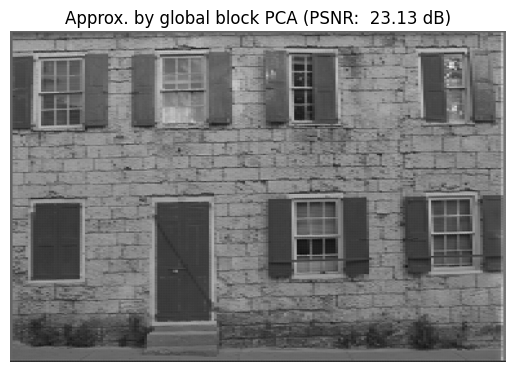

In [6]:
from torch.nn.functional import unfold, fold

# Reshape
if isMatlabComatible:
    colblks = unfold(img.permute(0,2,1), kernel_size=blksz, stride=blksz)
else:
    colblks = unfold(img, kernel_size=blksz, stride=blksz)
# PCA
mu = colblks.mean(dim=1).unsqueeze(1)
colblkszm = colblks - mu
C = colblkszm @ colblkszm.T / (colblkszm.shape[1]-1)
# SVD
U, S, V = C.svd()
idxS = S.argsort(descending=True)
V = V[:,idxS[:nCoefs]]
# Approxiamtion
if isMatlabComatible:
    gbpcaimg = fold(V @ V.T @ (colblks-mu) + mu, output_size=(img.shape[2],img.shape[1]),kernel_size=blksz, stride=blksz)
    gbpcaimg = gbpcaimg.permute(0,2,1)
else:
    gbpcaimg = fold(V @ V.T @ (colblks-mu) + mu, output_size=img.shape[1:],kernel_size=blksz, stride=blksz)

# Calculate PSNR
mse = torch.mean((img - gbpcaimg)**2)
psnr = -20.0 * math.log10(math.sqrt(mse.item()))

# Display
plt.imshow(gbpcaimg.squeeze(), cmap='gray')
plt.title(f'Approx. by global block PCA (PSNR: {psnr:6.2f} dB)')
plt.axis('off')
plt.show()

## Local block PCA for reference

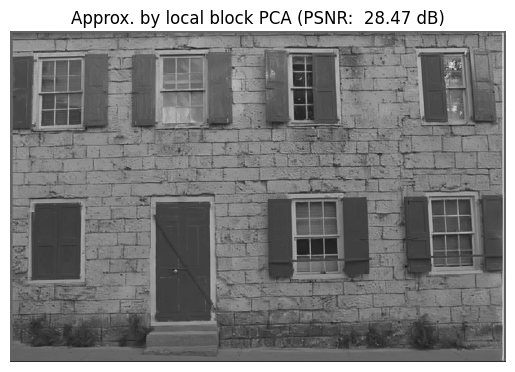

In [24]:
from support import fcn_extract_blks, fcn_place_blks

# Create Sub-images
szy, szx = img.shape[1:]
lbpcaimg = torch.zeros(szy, szx)
for iBlkRow in range(szy//blksz[0]):
    for iBlkCol in range(szx//blksz[1]):
        # Extract ky x kx blocks
        subblks = fcn_extract_blks(img, [iBlkRow, iBlkCol], blksz, [ky, kx])
        # Reshape
        if isMatlabComatible:
            colblks = unfold(subblks.permute(0,2,1), kernel_size=blksz, stride=blksz)
        else:
            colblks = unfold(subblks, kernel_size=blksz, stride=blksz)
        # PCA
        mu = colblks.mean(dim=1).unsqueeze(1)
        colblkszm = colblks - mu
        C = colblkszm @ colblkszm.T / (colblkszm.shape[1]-1)
        # SVD
        U, S, V = C.svd()
        idxS = S.argsort(descending=True)
        V = V[:,idxS[:nCoefs]]        
        # Approxiamtion
        targetblk = fcn_extract_blks(img, [iBlkRow, iBlkCol], blksz, [1, 1])
        if isMatlabComatible:
            targetblk = (V @ V.T @ (targetblk.T.reshape(-1)-mu.reshape(-1)) + mu.reshape(-1)).reshape(blksz[1],blksz[0])
            targetblk = targetblk.T
        else:
            targetblk = (V @ V.T @ (targetblk.reshape(-1)-mu.reshape(-1)) + mu.reshape(-1)).reshape(blksz)
        lbpcaimg = fcn_place_blks(lbpcaimg, targetblk, [iBlkRow, iBlkCol], blksz)

# Calculate PSNR
mse = torch.mean((img - lbpcaimg)**2)
psnr = -20.0 * math.log10(math.sqrt(mse.item()))

# Display
plt.imshow(lbpcaimg.squeeze(), cmap='gray')
plt.title(f'Approx. by local block PCA (PSNR: {psnr:6.2f} dB)')
plt.axis('off')
plt.show()

## Locally Structured Unitary Network (LSUN) for 2\-D Grayscale image

In [8]:
# Decimation factor (Strides)
stride = blksz

# Number of overlapping blocks (Polyphase order plus one)
ovlpFactor = (ky, kx)

# Max epochs
maxEpochs = 64

# Standard deviation of initial angles
stdInitAng = 0

# No DC-leakage
noDcLeakage = True


## Bivariate lattice\-structure of filter banks

As a base system for LSUN, let us adopt a multidimensional linear\-phase paraunitary filter banks (MD\-LPPUFB) ( or non\-separable oversampled lapped transform (NSOLT)) of  type\-I with the number of channels (the numbers of even and odd symmetric channels are identical to each other) and polyphase order (even):

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
$$E(z_{{\mathrm{v}}} ,z_h )=\left(\prod_{k_{{\mathrm{h}}} =1}^{N_{{\mathrm{h}}} /2} V_{2k_{{\mathrm{h}}} }^{\lbrace {\mathrm{h}}\rbrace } \bar{Q} (z_{{\mathrm{h}}} )V_{2k_{{\mathrm{h}}} -1}^{\lbrace {\mathrm{h}}\rbrace } Q(z_{{\mathrm{h}}} )\right)\left(\prod_{k_{{\mathrm{v}}} =1}^{N_{{\mathrm{v}}} /2} V_{2k_{{\mathrm{v}}} }^{\lbrace {\mathrm{v}}\rbrace } \bar{Q} (z_{{\mathrm{v}}} )V_{2k_{{\mathrm{v}}} -1}^{\lbrace {\mathrm{v}}\rbrace } Q(z_{{\mathrm{v}}} )\right)V_0 E_0 ,$$

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
$$R(z_{{\mathrm{v}}} ,z_h )=E^T (z_{{\mathrm{v}}}^{-1} ,z_{{\mathrm{h}}}^{-1} ),$$

where

-  $E(z_{{\mathrm{v}}} ,z_{{\mathrm{h}}} )$ :  Type\-I polyphase matrix of the analysis filter bank
-  $R(z_{{\mathrm{v}}} ,z_{{\mathrm{h}}} )$ : Type\-II polyphase matrix in the synthesis filter bank
-  $z_d \in \mathbb{C},d\in \lbrace {\mathrm{v}},{\mathrm{h}}\rbrace$ : The parameter of Z\-transformation direction
-  $N_d \in \mathbb{N},d\in \lbrace {\mathrm{v}},{\mathrm{h}}\rbrace$ : Polyphase order in direction $d$ (number of overlapping blocks)
-  $V_0 =\left(\begin{array}{cc} W_0  & O\newline O & U_0  \end{array}\right)\left(\begin{array}{c} I_{M/2} \newline O\newline I_{M/2} \newline O \end{array}\right)\in {\mathbb{R}}^{P\times M}$ , $V_n^{\lbrace d\rbrace } =\left(\begin{array}{cc} I_{P/2}  & O\newline O & U_n^{\lbrace d\rbrace }  \end{array}\right)\in {\mathbb{R}}^{P\times P} ,d\in \lbrace {\mathrm{v}},{\mathrm{h}}\rbrace$ , where $W_0 ,U_0 ,U_n^{\lbrace d\rbrace } \in {\mathbb{R}}^{P/2\times P/2}$ are orthonromal matrices.
-  $Q(z)=B_P \left(\begin{array}{cc} I_{P/2}  & O\newline O & z^{-1} I_{P/2}  \end{array}\right)B_P$ , $\bar{Q} (z)=B_P \left(\begin{array}{cc} zI_{P/2}  & O\newline O & I_{P/2}  \end{array}\right)B_P$ , $B_P =\frac{1}{\sqrt{2}}\left(\begin{array}{cc} I_{P/2}  & I_{P/2} \newline I_{P/2}  & -I_{P/2}  \end{array}\right)$

【Example】For $P/2=3$ , a parametric orthonormal matrix $U({\theta },{\mu })$ can be constructed by

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
$$U({\theta },{\mu })\colon =\left(\begin{array}{ccc} \mu_1  & 0 & 0\newline 0 & \mu_1  & 0\newline 0 & 0 & \mu_2  \end{array}\right)\left(\begin{array}{ccc} 1 & 0 & 0\newline 0 & \cos \theta_2  & -\sin \theta_2 \newline 0 & \sin \theta_2  & \cos \theta_2  \end{array}\right)\left(\begin{array}{ccc} \cos \theta_1  & 0 & -\sin \theta_1 \newline 0 & 1 & 0\newline \sin \theta_1  & 0 & \cos \theta_1  \end{array}\right)\left(\begin{array}{ccc} \cos \theta_0  & -\sin \theta_0  & 0\newline \sin \theta_0  & \cos \theta_0  & 0\newline 0 & 0 & 1 \end{array}\right),$$

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
$${U({\theta },{\mu })}^T =\left(\begin{array}{ccc} \cos \theta_0  & \sin \theta_0  & 0\newline -\sin \theta_0  & \cos \theta_0  & 0\newline 0 & 0 & 1 \end{array}\right)\left(\begin{array}{ccc} \cos \theta_1  & 0 & \sin \theta_1 \newline 0 & 1 & 0\newline -\sin \theta_1  & 0 & \cos \theta_1  \end{array}\right)\left(\begin{array}{ccc} 1 & 0 & 0\newline 0 & \cos \theta_2  & \sin \theta_2 \newline 0 & -\sin \theta_2  & \cos \theta_2  \end{array}\right)\left(\begin{array}{ccc} \mu_0  & 0 & 0\newline 0 & \mu_1  & 0\newline 0 & 0 & \mu_2  \end{array}\right),$$

where ${\theta }\in {\mathbb{R}}^{(P-2)P/8}$ and ${\mu }=\lbrace -1,1\rbrace^{P/2}$ . For the sake of simplification, the sign parameters $\mu_k$ are fixed to $-1$ for $U_n^{\lbrace d\rbrace }$ witn odd $n$ , otherwise they are fixed to $+1$ .


Partial differentiation can be, for examle, conducted as

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
$$\frac{\partial }{\partial \theta_1 }{U({\theta },{\mu })}^T =\left(\begin{array}{ccc} \cos \theta_0  & \sin \theta_0  & 0\newline -\sin \theta_0  & \cos \theta_0  & 0\newline 0 & 0 & 1 \end{array}\right)\left(\begin{array}{ccc} -\sin \theta_1  & 0 & \cos \theta_1 \newline 0 & 0 & 0\newline -\cos \theta_1  & 0 & -\sin \theta_1  \end{array}\right)\left(\begin{array}{ccc} 1 & 0 & 0\newline 0 & \cos \theta_2  & \sin \theta_2 \newline 0 & -\sin \theta_2  & \cos \theta_2  \end{array}\right)\left(\begin{array}{ccc} \mu_0  & 0 & 0\newline 0 & \mu_1  & 0\newline 0 & 0 & \mu_2  \end{array}\right).$$


A locally\-structured unitary network (LSUN) allows to change the parameters block by block.


【References】

-  MATLAB SaivDr Package: [https://github.com/msiplab/SaivDr](https://github.com/msiplab/SaivDr)
-  S. Muramatsu, K. Furuya and N. Yuki, "Multidimensional Nonseparable Oversampled Lapped Transforms: Theory and Design," in IEEE Transactions on Signal Processing, vol. 65, no. 5, pp. 1251\-1264, 1 March1, 2017, [doi: 10.1109/TSP.2016.2633240](https://ieeexplore.ieee.org/document/7762239).
-  S. Muramatsu, T. Kobayashi, M. Hiki and H. Kikuchi, "Boundary Operation of 2\-D Nonseparable Linear\-Phase Paraunitary Filter Banks," in IEEE Transactions on Image Processing, vol. 21, no. 4, pp. 2314\-2318, April 2012, doi: 10.1109/TIP.2011.2181527.
-  S. Muramatsu, M. Ishii and Z. Chen, "Efficient parameter optimization for example\-based design of nonseparable oversampled lapped transform," 2016 IEEE International Conference on Image Processing (ICIP), Phoenix, AZ, 2016, pp. 3618\-3622, doi: 10.1109/ICIP.2016.7533034.
-  Furuya, K., Hara, S., Seino, K., & Muramatsu, S. (2016). Boundary operation of 2D non\-separable oversampled lapped transforms. *APSIPA Transactions on Signal and Information Processing, 5*, E9. doi:10.1017/ATSIP.2016.3.
-  S. Muramatsu, A. Yamada and H. Kiya, "A design method of multidimensional linear\-phase paraunitary filter banks with a lattice structure," in IEEE Transactions on Signal Processing, vol. 47, no. 3, pp. 690\-700, March 1999,[doi: 10.1109/78.747776](https://ieeexplore.ieee.org/document/747776).
### Definition of custom layers and networks

Use a custom layer of Deep Learning Toolbox to implement Analysis LSUN.

#### Definition of layers w/ Learnable properties
-  Initial rotation: $V_{0,b}$ (tansacnet.lsun.lsunInitialRotationLayer)
-  Intermediate rotation: $V_{n,b}^{\lbrace d\rbrace }$ (tansacnet.lsun.lsunIntermediateRotationLayer)
#### Definition of layers w/o Learnable properties
-  Bivariate DCT (2\-D IDCT): $E_0$ (tansacnet.lsun.lsunBlockDctLayer)
-  Vertical up extension: $Q(z_{{\mathrm{v}}} )$ (tansacnet.lsun.lsunAtomExtensionLayer)
-  Vertical down extension: $\bar{Q} (z_{{\mathrm{v}}} )$  (tansacnet.lsun.lsunAtomExtensionLayer)
-  Horizontal left extension: $Q(z_{{\mathrm{h}}} )$ (tansacnet.lsun.lsunAtomExtensionLayer)
-  Horizontal right extension: $\bar{Q} (z_{{\mathrm{h}}} )$ (tansacnet.lsun.lsunAtomExtensionLayer)

In [9]:

from torch_tansacnet import LsunAnalysis2dNetwork
from torch_tansacnet import LsunSynthesis2dNetwork 
from torch_tansacnet import Direction
if torch.cuda.is_available():
    device = torch.device('cuda')

analysisnet = LsunAnalysis2dNetwork(
    input_size=[szy, szx],
    stride=stride,
    overlapping_factor=ovlpFactor,
    no_dc_leakage=noDcLeakage,
    device=device
)
synthesisnet = LsunSynthesis2dNetwork(
    input_size=[szy, szx],
    stride=stride,
    overlapping_factor=ovlpFactor,
    no_dc_leakage=noDcLeakage,
    device=device
)



In [10]:
from torchinfo import summary

batch_size = 1
nDecs = stride[Direction.VERTICAL] * stride[Direction.HORIZONTAL]
summary(analysisnet, input_size=(batch_size, 1, szy, szx))
summary(synthesisnet, input_size=(batch_size,szy//stride[Direction.VERTICAL], szx//stride[Direction.HORIZONTAL], nDecs))

Layer (type:depth-idx)                                            Output Shape              Param #
LsunSynthesis2dNetwork                                            [1, 1, 512, 768]          --
├─ModuleList: 1-1                                                 --                        --
│    └─Sequential: 2-1                                            --                        --
│    │    └─LsunIntermediateRotation2dLayer: 3-1                  [1, 128, 192, 16]         688,128
│    │    └─LsunAtomExtension2dLayer: 3-2                         [1, 128, 192, 16]         --
│    │    └─LsunIntermediateRotation2dLayer: 3-3                  [1, 128, 192, 16]         688,128
│    │    └─LsunAtomExtension2dLayer: 3-4                         [1, 128, 192, 16]         --
│    │    └─LsunIntermediateRotation2dLayer: 3-5                  [1, 128, 192, 16]         688,128
│    │    └─LsunAtomExtension2dLayer: 3-6                         [1, 128, 192, 16]         --
│    │    └─LsunIntermediateRo

In [11]:
from torch_tansacnet import OrthonormalTransform
def init_angles(m):
    if type(m) == OrthonormalTransform:
        torch.nn.init.normal_(m.angles, mean=0, std=stdInitAng)

analysisnet.apply(init_angles)
synthesisnet = analysisnet.T

### Confirmation of the adjoint relation (perfect reconstruction)

In [12]:
import cProfile

u = torch.rand([batch_size, 1, szy, szx], dtype=torch.float32, device='cuda' if torch.cuda.is_available() else 'cpu')

profiler = cProfile.Profile()
profiler.enable()

x = analysisnet(u)
y = synthesisnet(x)

profiler.disable()
profiler.print_stats(sort='cumtime')

print(f'MSE: {torch.mean((u-y)**2).item()}')

         14682585 function calls (13502839 primitive calls) in 547.609 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        3    0.000    0.000  547.609  182.536 interactiveshell.py:3541(run_code)
        3    0.000    0.000  547.609  182.536 {built-in method builtins.exec}
 294946/2    0.760    0.000  547.609  273.804 module.py:1528(_wrapped_call_impl)
 294946/2    1.459    0.000  547.609  273.804 module.py:1534(_call_impl)
        2    0.000    0.000  547.608  273.804 container.py:215(forward)
       12    0.000    0.000  528.150   44.013 orthonormalTransform.py:67(forward)
       12   18.253    1.521  528.150   44.013 orthonormalTransform.py:74(forward_cuda)
   294912    2.145    0.000  506.833    0.002 orthonormalTransform.py:228(forward)
   294920    1.691    0.000  503.537    0.002 function.py:582(apply)
   294920    8.790    0.000  496.864    0.002 {built-in method apply}
   294912  466.247    0.002  472.810    

## Parameter optimization and approximation

In [13]:
# Define model
import torch.nn as nn
from torch_tansacnet.lsunUtility import ForwardTruncationLayer

maskLayer = ForwardTruncationLayer(
    number_of_channels = nCoefs, 
    stride = stride)
trainnet = nn.Sequential(analysisnet, maskLayer)
summary(trainnet, input_size=(batch_size, 1, szy, szx))



Layer (type:depth-idx)                                                 Output Shape              Param #
Sequential                                                             [1, 128, 192, 2]          --
├─LsunAnalysis2dNetwork: 1-1                                           [1, 128, 192, 16]         --
│    └─ModuleList: 2-1                                                 --                        --
│    │    └─Sequential: 3-1                                            --                        4,128,768
├─ForwardTruncationLayer: 1-2                                          [1, 128, 192, 2]          --
Total params: 4,128,768
Trainable params: 4,128,768
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0
Input size (MB): 1.57
Forward/backward pass size (MB): 9.44
Params size (MB): 16.52
Estimated Total Size (MB): 27.53


Loss function


&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $L({\theta })=\|x{\|}_2^2 -\|F_{{\theta }} (x){\|}_2^2$ ,


where $F_{{\theta }} (\cdot )$ is a unitaly analyzer with a coefficient mask. $L({\theta })\ge 0$ is guaranteed.

In [14]:
energy_loss = lambda y,x: torch.sum(x**2)-torch.sum(y**2)

In [15]:
analysisnet.apply(init_angles)

# Training
momentum = 0.9
initialLearnRate = 1e-1
epoch = 0

profiler = cProfile.Profile()
profiler.enable()


# Optimizer
optimizer = torch.optim.SGD(trainnet.parameters(), lr=initialLearnRate, momentum=momentum)

# Loop over epochs.
while epoch < 2: # maxEpochs: 
    trainnet.train()
    
    epoch = epoch + 1
    x = torch.Tensor(img).unsqueeze(0).to(device)

    # Compute energy loss
    pred = trainnet(x)
    loss = energy_loss(pred,x)

    # Backpropagation
    loss.backward()
    optimizer.step()
    #optimizer.zero_grad()

    print(loss)

profiler.disable()
profiler.print_stats(sort='cumtime')

tensor(2804.9609, device='cuda:0', grad_fn=<SubBackward0>)
tensor(2755.7109, device='cuda:0', grad_fn=<SubBackward0>)
         27231196 function calls (24281719 primitive calls) in 14554.878 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        3    0.000    0.000 14555.482 4851.827 interactiveshell.py:3541(run_code)
        3    0.000    0.000 14555.482 4851.827 {built-in method builtins.exec}
        2    0.000    0.000 14043.658 7021.829 _tensor.py:466(backward)
        2    0.000    0.000 14043.658 7021.829 __init__.py:165(backward)
        2    0.000    0.000 14043.658 7021.829 graph.py:739(_engine_run_backward)
        2 14043.658 7021.829 14043.658 7021.829 {method 'run_backward' of 'torch._C._EngineBase' objects}
 294950/2    0.755    0.000  498.224  249.112 module.py:1528(_wrapped_call_impl)
 294950/2    1.376    0.000  498.224  249.112 module.py:1534(_call_impl)
      4/2    0.000    0.000  498.223  249.112 co

## Approximation by LSUN\-base linear autoencoder

In [16]:
""" 
import tansacnet.lsun.*
lsunlgraph = fcn_createlsunlgraph2d([],...
    'InputSize',[szy szx],...
    'Stride',stride,...
    'OverlappingFactor',ovlpFactor,...
    'NumberOfVanishingMoments',noDcLeakage,...
    'Mode','Whole');
trainlgraph = layerGraph(trainnet);
lsunlgraph = fcn_cpparamsana2syn(lsunlgraph,trainlgraph);
""" 

" \nimport tansacnet.lsun.*\nlsunlgraph = fcn_createlsunlgraph2d([],...\n    'InputSize',[szy szx],...\n    'Stride',stride,...\n    'OverlappingFactor',ovlpFactor,...\n    'NumberOfVanishingMoments',noDcLeakage,...\n    'Mode','Whole');\ntrainlgraph = layerGraph(trainnet);\nlsunlgraph = fcn_cpparamsana2syn(lsunlgraph,trainlgraph);\n"

In [17]:
""" 
lsunlgraph = fcn_cpparamssyn2ana(lsunlgraph,lsunlgraph);
""" 

' \nlsunlgraph = fcn_cpparamssyn2ana(lsunlgraph,lsunlgraph);\n'

In [18]:
""" 
%nLevels = 1;
%for iLv = nLevels:-1:1
iLv = 1;
strLv = sprintf('Lv%0d_',iLv);
lsunlgraph = lsunlgraph.disconnectLayers([strLv 'AcOut'],[strLv 'AcIn']);
% For AC
lsunlgraph = lsunlgraph.addLayers(...
    maskLayer('Name',[strLv 'AcMask'],'Mask',coefMask(2:end),...
    'NumberOfChannels',nChsTotal-1));
lsunlgraph = lsunlgraph.connectLayers([strLv 'AcOut'],[strLv 'AcMask']);
lsunlgraph = lsunlgraph.connectLayers([strLv 'AcMask'],[strLv 'AcIn']);
%strLvPre = strLv;
%end

figure
plot(lsunlgraph)
title('Linear autoencoder with LSUN')
""" 

" \n%nLevels = 1;\n%for iLv = nLevels:-1:1\niLv = 1;\nstrLv = sprintf('Lv%0d_',iLv);\nlsunlgraph = lsunlgraph.disconnectLayers([strLv 'AcOut'],[strLv 'AcIn']);\n% For AC\nlsunlgraph = lsunlgraph.addLayers(...\n    maskLayer('Name',[strLv 'AcMask'],'Mask',coefMask(2:end),...\n    'NumberOfChannels',nChsTotal-1));\nlsunlgraph = lsunlgraph.connectLayers([strLv 'AcOut'],[strLv 'AcMask']);\nlsunlgraph = lsunlgraph.connectLayers([strLv 'AcMask'],[strLv 'AcIn']);\n%strLvPre = strLv;\n%end\n\nfigure\nplot(lsunlgraph)\ntitle('Linear autoencoder with LSUN')\n"


Predict


In [19]:
""" 
lsunnet = assembleNetwork(lsunlgraph);
lsunaimg = lsunnet.predict(img);
""" 

' \nlsunnet = assembleNetwork(lsunlgraph);\nlsunaimg = lsunnet.predict(img);\n'

## Results

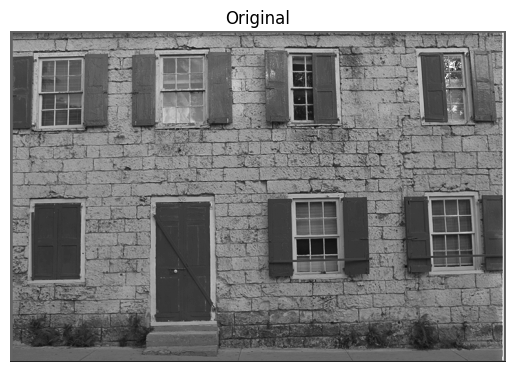

In [20]:
# Image data store
plt.imshow(img.squeeze(), cmap='gray')
plt.title(f'Original')
plt.axis('off')
plt.show()

In [21]:
""" 
figure
imshow(lbpcaimg)
title("Approx. by Local block PCA (PSNR: " + num2str(psnr(img,lbpcaimg))+" dB)")
""" 

' \nfigure\nimshow(lbpcaimg)\ntitle("Approx. by Local block PCA (PSNR: " + num2str(psnr(img,lbpcaimg))+" dB)")\n'

In [22]:
""" 
figure
imshow(gbpcaimg)
title("Approx. by Global block PCA (PSNR: " + num2str(psnr(img,gbpcaimg))+" dB)")
""" 

' \nfigure\nimshow(gbpcaimg)\ntitle("Approx. by Global block PCA (PSNR: " + num2str(psnr(img,gbpcaimg))+" dB)")\n'

In [23]:
""" 
figure
imshow(lsunaimg)
title("Approx. by LSUN (PSNR: " + num2str(psnr(img,im2double(lsunaimg)))+" dB)")
""" 

' \nfigure\nimshow(lsunaimg)\ntitle("Approx. by LSUN (PSNR: " + num2str(psnr(img,im2double(lsunaimg)))+" dB)")\n'